In [1]:
import torch
# Is CUDA available now?\
print('CUDA available: {}'.format(torch.cuda.is_available()))

CUDA available: True


In [2]:
!conda env list

# conda environments:
#
base                     /home/theekshana/anaconda3
YOLO3D                *  /home/theekshana/anaconda3/envs/YOLO3D



In [ ]:
!chmod 777 -R /home/theekshana/Documents/visualDet3D

In [ ]:
torch.version.cuda

In [3]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm

In [4]:
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

In [5]:
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

CUDA available: True


In [6]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn

# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

In [7]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [8]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [9]:
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    return np.clip(rgb_image, 0, 255)

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.020579099655151367 seconds at call time 2
PSM Cos Volume takes 0.009275674819946289 seconds at call time 3
Cost Volume takes 0.16283798217773438 seconds at call time 1


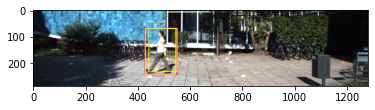

In [11]:
index = 0
a = compute_once(index)

/home/theekshana/Documents/visualDet3D/visualDet3D/data/kitti/dataset/stereo_dataset.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float(), torch.tensor(P2).float(), torch.tensor(P3).float(), label, bbox2ds, bbox3ds
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.008947610855102539 seconds at call time 1


/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


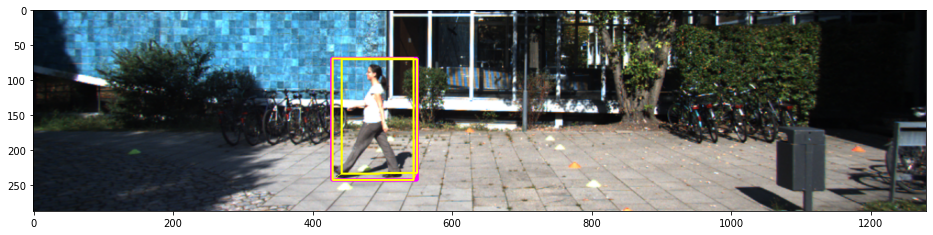

In [10]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
# index += 1
index=0
a = compute_once(index, is_test_train=False, is_draw=True)

In [ ]:
for index in range(20,40):
    a = compute_once(index, is_test_train=False, is_draw=True)
    print(index)
    plt.show()

In [ ]:
<?xml version="1.0"?>
<launch>
    <arg name="KITTI_OBJ_DIR" default="../../visualDet3D/data/kitti_obj/training"/>
    <arg name="KITTI_RAW_DIR" default="../../visualDet3D/data/kitti_raw"/>
    <!--  do not provide KITTI_DEPTH_DIR to the node to disable depth prediction-->
    <arg name="KITTI_DEPTH_DIR" default="/data/data_depth_annotated"/> 
    <node pkg="kitti_visualize" type="kitti_visualize_node.py" name="kitti_visualize_node" output="screen">
        <param name="KITTI_OBJ_DIR" value="$(arg KITTI_OBJ_DIR)"/>
        <param name="KITTI_RAW_DIR" value="$(arg KITTI_RAW_DIR)"/>
        <param name="KITTI_DEPTH_DIR" value="$(arg KITTI_DEPTH_DIR)"/>
        <param name="Image_PointCloud_Depth" value="3"/>
    </node>
    <node pkg="rviz" type="rviz" name="rviz" args="-d $(find kitti_visualize)/rviz/rviz.rviz"/>
    <node pkg="kitti_visualize" type="gui_controller_node.py" name="GUI_controller_node" output="screen" respawn="false" respawn_delay="0">

    </node>
</launch>

In [ ]:
KITTI_NAMES = ['Car', 'Pedestrian', 'Cyclist'] #,  'Van', 'Truck']
KITTI_COLORS = [(  0, 50, 182),
                (  0,180,  60),
                (119, 11,  32),
                (  0,  0, 142), 
                (  0,  0, 70)
                ]

In [ ]:
#!/usr/bin/env python
import os
import numpy as np
import rospy
from visualization_msgs.msg import Marker
import scipy.io as sio
from .constants import KITTI_COLORS, KITTI_NAMES

def color_pointcloud(pts, image, T, P2):
    hfiller = np.expand_dims(np.ones(pts.shape[0]), axis=1)
    pts_hT = np.hstack((pts, hfiller)).T #(4, #pts)
    if T.shape == (3, 4):
        T1 = np.eye(4)
        T1[0: 3] = T.copy()
    else:
        T1 = T.copy()
    pts_cam_T = T1.dot(pts_hT) # (4, #pts)

    pixels_T = P2.dot(pts_cam_T) #(3, #pts)
    pixels = pixels_T.T
    pixels[:, 0] /= pixels[:, 2] + 1e-6
    pixels[:, 1] /= pixels[:, 2] + 1e-6
    w_coordinate = pixels[:, 0].astype(np.int32)
    h_coordinate = pixels[:, 1].astype(np.int32)
    w_coordinate[w_coordinate <= 0] = 0
    w_coordinate[w_coordinate >= image.shape[1]] = image.shape[1] - 1
    h_coordinate[h_coordinate <= 0] = 0
    h_coordinate[h_coordinate >= image.shape[0]] = image.shape[0] - 1
    
    bgr = image[h_coordinate, w_coordinate, :]/ 256.0
    return np.concatenate([pts, bgr], axis=1).astype(np.float32)

def read_labels(file):
    """Read objects 3D bounding boxes from a label file.

    Args:
        file: string of path to the label file

    Returns:
        objects: List[Dict];
        object['whl'] = [w, h, l]
        object['xyz'] = [x, y, z] # center point location in center camera coordinate
        object['theta']: float
        object['score']: float
        object['type_name']: string
    """
    objects = []
    with open(file, 'r') as f:
        for line in f.readlines():
            objdata = line.split()
            class_name = objdata[0]
            if class_name in KITTI_NAMES:
                whl = [float(objdata[9]), float(objdata[8]), float(objdata[10])]
                xyz = [float(objdata[11]), float(objdata[12]) - 0.5 * whl[1], float(objdata[13])]
                theta = float(objdata[14])
                if len(objdata) > 15:
                    score = float(objdata[15])
                else:
                    score = 1.0
                objects.append(
                    dict(whl=whl, xyz=xyz, theta=theta, type_name=class_name, score=score)
                )
    return objects

def read_calib_from_detection(file):
    """ read P2, P3, T from a detection calibration file
    """
    P2 = None
    P2 = None
    R0_rect = None
    Tr_velo2cam = None
    with open(file, 'r') as f:
        for line in f.readlines():
            if line.startswith("R0_rect:"):
                data = line.split(" ")
                R0_rect = np.array([float(x) for x in data[1:10]])
                R0_rect = np.reshape(R0_rect, [3, 3])
            if line.startswith("Tr_velo_to_cam:"):
                data = line.split(" ")
                Tr_velo2cam = np.array([float(x) for x in data[1:13]])
                Tr_velo2cam = np.reshape(Tr_velo2cam, [3, 4]) 
            if line.startswith("P2:"):
                data = line.split(" ")
                P2 = np.array([float(x) for x in data[1:13]])
                P2 = np.reshape(P2, [3, 4])
            if line.startswith("P3:"):
                data = line.split(" ")
                P3 = np.array([float(x) for x in data[1:13]])
                P3 = np.reshape(P3, [3, 4]) 
    assert Tr_velo2cam is not None, "can not find T_velo2cam in file {}".format(file)
    assert R0_rect is not None, "can not find R in file {}".format(file)
    assert P2 is not None, "can not find P2 in file {}".format(file)
    assert P3 is not None, "can not find P3 in file {}".format(file)

    T_velo2cam = np.dot(R0_rect, Tr_velo2cam)
    return P2, P3, T_velo2cam

def read_T_from_sequence(file):
    """ read T from a sequence file calib_velo_to_cam.txt
    """
    R = None
    T = None
    with open(file, 'r') as f:
        for line in f.readlines():
            if line.startswith("R:"):
                data = line.split(" ")
                R = np.array([float(x) for x in data[1:10]])
                R = np.reshape(R, [3, 3])
            if line.startswith("T:"):
                data = line.split(" ")
                T = np.array([float(x) for x in data[1:4]])
                T = np.reshape(T, [3, 1]) 
    assert R is not None, "can not find R in file {}".format(file)
    assert T is not None, "can not find T in file {}".format(file)

    T_velo2cam = np.eye(4)
    T_velo2cam[0:3, 0:3] = R
    T_velo2cam[0:3, 3:4] = T
    return T_velo2cam

def read_Timu_from_sequence(file):
    R = None
    T = None
    with open(file, 'r') as f:
        for line in f.readlines():
            if line.startswith("R:"):
                data = line.split(" ")
                R = np.array([float(x) for x in data[1:10]])
                R = np.reshape(R, [3, 3])
            if line.startswith("T:"):
                data = line.split(" ")
                T = np.array([float(x) for x in data[1:4]])
                T = np.reshape(T, [3, 1]) 
    assert R is not None, "can not find R in file {}".format(file)
    assert T is not None, "can not find T in file {}".format(file)
    T_imu2velo = np.eye(4)
    T_imu2velo[0:3, 0:3] = R
    T_imu2velo[0:3, 3:4] = T
    return T_imu2velo

def read_P23_from_sequence(file):
    """ read P2 and P3 from a sequence file calib_cam_to_cam.txt
    """
    P2 = None
    P3 = None
    with open(file, 'r') as f:
        for line in f.readlines():
            if line.startswith("P_rect_02"):
                data = line.split(" ")
                P2 = np.array([float(x) for x in data[1:13]])
                P2 = np.reshape(P2, [3, 4])
            if line.startswith("P_rect_03"):
                data = line.split(" ")
                P3 = np.array([float(x) for x in data[1:13]])
                P3 = np.reshape(P3, [3, 4])
    assert P2 is not None, "can not find P2 in file {}".format(file)
    assert P3 is not None, "can not find P3 in file {}".format(file)
    return P2, P3

def determine_date_index(base_dir, index):
    date_times = os.listdir(base_dir)
    residual_index = index
    date_times.sort()
    for date_time in date_times:
        date_dir = os.path.join(base_dir, date_time)
        sequences_at_date = [file for file in os.listdir(date_dir) if not file.endswith("txt")]
        sequences_at_date.sort()
        if residual_index >= len(sequences_at_date):
            residual_index = residual_index - len(sequences_at_date)
        else:
            break
    else:
        rospy.logwarn("index {} is larger than the total number of sequences {} in {}".format(index, index-residual_index, base_dir))
        return None, None, None
    
    return date_dir, sequences_at_date[residual_index]

def get_files(base_dir, index, is_sequence, depth_dir=None):
    """Retrieve a dictionary of filenames, including calibration(P2, P3, R, T), left_image, right_image, point_cloud, labels(could be none)

        if is_sequence:
            Will read from KITTI raw data. 
            base_dir: str, should be absolute file path to kitti_raw
            index: int, sequence number at that datetime <1> -> <2011_09_26_drive_0001_sync>
        else:
            Will read from KITTI detection data.
            base_dir: str, should be abolutie file path to <training/testing>
            index: int, index number for calib/image/velodyne
    """
    output_dict = {
        "calib":{
            "P2":None,
            "P3":None,
            "T_velo2cam":None,
            "T_imu2velo":None,
        },
        "left_image":"",
        "right_image":"",
        "point_cloud":"",
        "label":None,
        "additional_label":None,
        "odom_array":None,
    }
    if is_sequence:
        
        date_dir, sequence = determine_date_index(base_dir, index)
        cam_calib_file = os.path.join(date_dir, "calib_cam_to_cam.txt")
        P2, P3 = read_P23_from_sequence(cam_calib_file)
        velo_calib_file = os.path.join(date_dir, "calib_velo_to_cam.txt")
        T_velo2cam = read_T_from_sequence(velo_calib_file)
        imu_calib_file = os.path.join(date_dir, 'calib_imu_to_velo.txt')
        T_imu2velo = read_Timu_from_sequence(imu_calib_file)
        output_dict["calib"]["P2"] = P2
        output_dict["calib"]["P3"] = P3
        output_dict["calib"]["T_velo2cam"] = T_velo2cam
        output_dict["calib"]["T_imu2velo"] = T_imu2velo

        left_dir = os.path.join(date_dir, sequence, "image_02", "data")
        left_images = os.listdir(left_dir)
        left_images.sort()
        left_images = [os.path.join(left_dir, left_image) for left_image in left_images]

        right_dir = os.path.join(date_dir, sequence, "image_03", "data")
        right_images= os.listdir(right_dir)
        right_images.sort()
        right_images = [os.path.join(right_dir, right_image) for right_image in right_images]

        velo_dir = os.path.join(date_dir, sequence, "velodyne_points", "data")
        velodynes = os.listdir(velo_dir)
        velodynes.sort()
        velodynes = [os.path.join(velo_dir, velodyne) for velodyne in velodynes]


        odometry_mat = os.path.join(date_dir, sequence, 'oxts', 'pose.mat') # pose mat can be generated with official matlab toolkits
        if os.path.isfile(odometry_mat):
            pose_dict = sio.loadmat(odometry_mat)
            odom_array = pose_dict[[key for key in list(pose_dict.keys()) if not key.startswith('__')][0]] # the only non "__" key, should be a N, 4, 4 matrix
        else:
            odom_array = np.stack([np.eye(4) for _ in range(len(left_images))], dim=0) # just not outputing odom is also fine.

        if not depth_dir is None:
            if sequence in os.listdir(os.path.join(depth_dir, "train")):
                depth_image_dir = os.path.join(depth_dir, "train", sequence, 'proj_depth', 'groundtruth', 'image_02')
                depth_images = os.listdir(depth_image_dir)
                depth_images.sort()
                depth_images = [os.path.join(depth_image_dir, depth_image) for depth_image in depth_images]
                output_dict["depth_images"] = depth_images
            if sequence in os.listdir(os.path.join(depth_dir, "val")):
                depth_image_dir = os.path.join(depth_dir, "val", sequence, 'proj_depth', 'groundtruth', 'image_02')
                depth_images = os.listdir(depth_image_dir)
                depth_images.sort()
                depth_images = [os.path.join(depth_image_dir, depth_image) for depth_image in depth_images]
                output_dict["depth_images"] = depth_images
                rospy.loginfo("the current sequence {} is in validation set".format(sequence))

        output_dict["left_image"] = left_images
        output_dict["right_image"] = right_images
        output_dict["point_cloud"] = velodynes
        output_dict["odom_array"] = odom_array

    else:
        kitti_ind = "%06d" % index
        left_image = os.path.join(base_dir, "image_2", kitti_ind + ".png")
        right_image = os.path.join(base_dir, "image_3", kitti_ind + ".png")
        point_cloud = os.path.join(base_dir, "velodyne", kitti_ind + ".bin")
        calib_file = os.path.join(base_dir, "calib", kitti_ind + ".txt")
        label_file = os.path.join(base_dir, "label_2", kitti_ind + ".txt")
        additional_label_file = os.path.join(base_dir, "additional_label_2", kitti_ind + ".txt")
        depth_file = os.path.join(base_dir, "depth", kitti_ind + ".png")
        P2, P3, T_velo2cam = read_calib_from_detection(calib_file)

        output_dict["left_image"] = left_image
        output_dict["right_image"] = right_image
        output_dict["point_cloud"] = point_cloud
        output_dict["calib"]["P2"] = P2
        output_dict["calib"]["P3"] = P3
        output_dict["calib"]["T_velo2cam"] = T_velo2cam

        if os.path.isfile(label_file):
            output_dict["label"] = label_file

        if os.path.isfile(depth_file):
            output_dict["depth_image"] = depth_file
        
        if os.path.isfile(additional_label_file):
            output_dict["additional_label"] = additional_label_file

    return output_dict

        
if __name__ == "__main__":
    output_dict1 = get_files("/home/hins/kitti/2011_09_26", 1, True)
    output_dict2 = get_files("/home/hins/Desktop/M3D-RPN/data/kitti/training", 1, False)
    a = 1


In [ ]:
#!/usr/bin/env python
import rospy 
import numpy as np
from math import sin, cos
from sensor_msgs.msg import CameraInfo, Image, PointCloud2
from geometry_msgs.msg import Point
from visualization_msgs.msg import Marker, MarkerArray
from std_msgs.msg import String, Int32, Bool
import tf
from cv_bridge import CvBridge
import cv2
import std_msgs.msg as std_msgs
import sensor_msgs.msg as sensor_msgs
from .constants import KITTI_NAMES, KITTI_COLORS

def depth_image_to_point_cloud_array(depth_image, K, parent_frame="left_camera", rgb_image=None):
    """  convert depth image into color pointclouds [xyzbgr]
    
    """
    depth_image = np.copy(depth_image) / 256.0
    w_range = np.arange(0, depth_image.shape[1], dtype=np.float32)
    h_range = np.arange(0, depth_image.shape[0], dtype=np.float32)
    w_grid, h_grid = np.meshgrid(w_range, h_range) #[H, W]
    K_expand = np.eye(4)
    K_expand[0:3, 0:3] = K
    K_inv = np.linalg.inv(K_expand) #[4, 4]

    #[H, W, 4, 1]
    expand_image = np.stack([w_grid * depth_image, h_grid * depth_image, depth_image, np.ones_like(depth_image)], axis=2)[...,np.newaxis]

    pc_3d = np.matmul(K_inv, expand_image)[..., 0:3, 0] #[H, W, 3]
    if rgb_image is not None:
        pc_3d = np.concatenate([pc_3d, rgb_image/256.0], axis=2).astype(np.float32)
    point_cloud = pc_3d[depth_image > 0,:]
    
    return point_cloud

def line_points_from_3d_bbox(x, y, z, w, h, l, theta):
    corner_matrix = np.array(
        [[-1, -1, -1],
        [ 1, -1, -1],
        [ 1,  1, -1],
        [ 1,  1,  1],
        [ 1, -1,  1],
        [-1, -1,  1],
        [-1,  1,  1],
        [-1,  1, -1]], dtype=np.float32
    )
    relative_eight_corners = 0.5 * corner_matrix * np.array([w, h, l]) #[8, 3]

    _cos = cos(theta)
    _sin = sin(theta)

    rotated_corners_x, rotated_corners_z = (
            relative_eight_corners[:, 2] * _cos +
                relative_eight_corners[:, 0] * _sin,
        -relative_eight_corners[:, 2] * _sin +
            relative_eight_corners[:, 0] * _cos
        ) #[8]
    rotated_corners = np.stack([rotated_corners_x, relative_eight_corners[:,1], rotated_corners_z], axis=-1) #[8, 3]
    abs_corners = rotated_corners + np.array([x, y, z])  # [8, 3]

    points = []
    for i in range(1, 5):
        points += [
            Point(x=abs_corners[i, 0], y=abs_corners[i, 1], z=abs_corners[i, 2]),
            Point(x=abs_corners[i%4+1, 0], y=abs_corners[i%4+1, 1], z=abs_corners[i%4+1, 2])
        ]
        points += [
            Point(x=abs_corners[(i + 4)%8, 0], y=abs_corners[(i + 4)%8, 1], z=abs_corners[(i + 4)%8, 2]),
            Point(x=abs_corners[((i)%4 + 5)%8, 0], y=abs_corners[((i)%4 + 5)%8, 1], z=abs_corners[((i)%4 + 5)%8, 2])
        ]
    points += [
        Point(x=abs_corners[2, 0], y=abs_corners[2, 1], z=abs_corners[2, 2]),
        Point(x=abs_corners[7, 0], y=abs_corners[7, 1], z=abs_corners[7, 2]),
        Point(x=abs_corners[3, 0], y=abs_corners[3, 1], z=abs_corners[3, 2]),
        Point(x=abs_corners[6, 0], y=abs_corners[6, 1], z=abs_corners[6, 2]),

        Point(x=abs_corners[4, 0], y=abs_corners[4, 1], z=abs_corners[4, 2]),
        Point(x=abs_corners[5, 0], y=abs_corners[5, 1], z=abs_corners[5, 2]),
        Point(x=abs_corners[0, 0], y=abs_corners[0, 1], z=abs_corners[0, 2]),
        Point(x=abs_corners[1, 0], y=abs_corners[1, 1], z=abs_corners[1, 2])
    ]

    return points

def object_to_marker(obj, frame_id="base", marker_id=None, duration=0.15, color=None):
    """ Transform an object to a marker.

    Args:
        obj: Dict
        frame_id: string; parent frame name
        marker_id: visualization_msgs.msg.Marker.id
        duration: the existence time in rviz
    
    Return:
        marker: visualization_msgs.msg.Marker

    object dictionary expectation:
        object['whl'] = [w, h, l]
        object['xyz'] = [x, y, z] # center point location in center camera coordinate
        object['theta']: float
        object['score']: float
        object['type_name']: string # should have name in constant.KITTI_NAMES

    """
    marker = Marker()
    marker.header.stamp = rospy.Time.now()
    marker.header.frame_id = frame_id
    if marker_id is not None:
        marker.id = marker_id
    marker.type = 5
    marker.scale.x = 0.05

    object_cls_index = KITTI_NAMES.index(obj["type_name"])
    if color is None:
        obj_color = KITTI_COLORS[object_cls_index] #[r, g, b]
    else:
        obj_color = color
    marker.color.r = obj_color[0] / 255.0
    marker.color.g = obj_color[1] / 255.0
    marker.color.b = obj_color[2] / 255.0
    marker.color.a = obj["score"]
    marker.points = line_points_from_3d_bbox(obj["xyz"][0], obj["xyz"][1], obj["xyz"][2], obj["whl"][0], obj["whl"][1], obj["whl"][2], obj["theta"])

    marker.lifetime = rospy.Duration.from_sec(duration)
    return marker

def publish_tf(P2=None, P3=None, T=None, T_imu=None):
    """ Publish camera, velodyne transform from P2, P3, T
    """
    br = tf.TransformBroadcaster()

    ## broadcast translation and rotation in velodyne T
    if T is not None:
        homo_R = np.eye(4)
        homo_R[0:3, 0:3] = T[0:3, 0:3]
        br.sendTransform(
            (T[0, 3], T[1, 3], T[2, 3]),
            tf.transformations.quaternion_from_matrix(homo_R),
            rospy.Time.now(),
            "velodyne",
            "camera_base"
        )

    ## broadcast the translation from world to base
    if T_imu is None:
        br.sendTransform(
            (0, 0, 0),
            # tf.transformations.quaternion_from_matrix(homo_R.T),
            [0.5, -0.5, 0.5, -0.5],
            rospy.Time.now(),
            "camera_base",
            "base_link"
        )
    else:
        T_cam2imu = np.linalg.inv(T_imu @ T)
        homo_R = np.eye(4)
        homo_R[0:3, 0:3] = T_cam2imu[0:3, 0:3]
        br.sendTransform(
            (T_cam2imu[0, 3], T_cam2imu[1, 3], T_cam2imu[2, 3]),
            tf.transformations.quaternion_from_matrix(homo_R),
            rospy.Time.now(),
            "camera_base",
            "base_link"
        )
    if P2 is not None:
    ## broadcast the translation in P2
        br.sendTransform(
            (-P2[0, 3] / P2[0, 0], 0, 0),
            tf.transformations.quaternion_from_euler(0, 0, 0),
            rospy.Time.now(),
            "left_camera",
            "camera_base"
        )
    if P3 is not None:
        ## broadcast translation in P3
        br.sendTransform(
            (-P3[0, 3] / P3[0, 0], 0, 0),
            tf.transformations.quaternion_from_euler(0, 0, 0),
            rospy.Time.now(),
            "right_camera",
            "camera_base"
        )

def publish_odom(R, T):
    br = tf.TransformBroadcaster()
    
    br.sendTransform(
        (T[0], T[1], T[2]),
        tf.transformations.quaternion_from_matrix(R),
        rospy.Time.now(),
        "base_link",
        "odom"
    )

def publish_image(image, image_publisher, camera_info_publisher, P, frame_id):
    """Publish image and info message to ROS.

    Args:
        image: numpy.ndArray.
        image_publisher: rospy.Publisher
        camera_info_publisher: rospy.Publisher, should publish CameraInfo
        P: projection matrix [3, 4]. though only [3, 3] is useful.
        frame_id: string, parent frame name.
    """
    bridge = CvBridge()
    image_msg = bridge.cv2_to_imgmsg(image, encoding="passthrough")
    image_msg.header.frame_id = frame_id
    image_msg.header.stamp = rospy.Time.now()
    image_publisher.publish(image_msg)

    camera_info_msg = CameraInfo()
    camera_info_msg.header.frame_id = frame_id
    camera_info_msg.header.stamp = rospy.Time.now()
    camera_info_msg.height = image.shape[0]
    camera_info_msg.width = image.shape[1]
    camera_info_msg.D = [0, 0, 0, 0, 0]
    camera_info_msg.K = np.reshape(P[0:3, 0:3], (-1)).tolist()
    P_no_translation = np.zeros([3, 4])
    P_no_translation[0:3, 0:3] = P[0:3, 0:3]
    camera_info_msg.P = np.reshape(P_no_translation, (-1)).tolist()

    camera_info_publisher.publish(camera_info_msg)

def array2pc2(points, parent_frame, field_names='xyza'):
    """ Creates a point cloud message.
    Args:
        points: Nxk array of xyz positions (m) and rgba colors (0..1)
        parent_frame: frame in which the point cloud is defined
        field_names : name for the k channels repectively i.e. "xyz" / "xyza"
    Returns:
        sensor_msgs/PointCloud2 message
    """
    ros_dtype = sensor_msgs.PointField.FLOAT32
    dtype = np.float32
    itemsize = np.dtype(dtype).itemsize

    data = points.astype(dtype).tobytes()

    fields = [sensor_msgs.PointField(
        name=n, offset=i*itemsize, datatype=ros_dtype, count=1)
        for i, n in enumerate(field_names)]

    header = std_msgs.Header(frame_id=parent_frame, stamp=rospy.Time.now())

    return sensor_msgs.PointCloud2(
        header=header,
        height=1,
        width=points.shape[0],
        is_dense=False,
        is_bigendian=False,
        fields=fields,
        point_step=(itemsize * len(field_names)),
        row_step=(itemsize * len(field_names) * points.shape[0]),
        data=data
    )

def publish_point_cloud(pointcloud, pc_publisher, frame_id, field_names='xyza'):
    """Convert point cloud array to PointCloud2 message and publish
    
    Args:
        pointcloud: point cloud array [N,3]/[N,4]
        pc_publisher: ROS publisher for PointCloud2
        frame_id: parent_frame name.
        field_names: name for each channel, ['xyz', 'xyza'...]
    """
    msg = array2pc2(pointcloud, frame_id, field_names)
    pc_publisher.publish(msg)

def clear_all_bbox(marker_publisher):
    clear_marker = Marker()
    clear_marker.action = 3
    if marker_publisher.data_class is Marker:
        marker_publisher.publish(clear_marker)
        return
    if marker_publisher.data_class is MarkerArray:
        marker_publisher.publish([clear_marker])


In [ ]:
#!/usr/bin/env python3
import numpy as np
import rospy 
import cv2
from utils import kitti_utils, ros_util
from sensor_msgs.msg import CameraInfo, Image, PointCloud2
from visualization_msgs.msg import Marker, MarkerArray
from std_msgs.msg import String, Int32, Bool, Float32

class KittiVisualizeNode:
    """ Main node for data visualization. Core logic lies in publish_callback.
    """
    def __init__(self):
        rospy.init_node("KittiVisualizeNode")
        rospy.loginfo("Starting KittiVisualizeNode.")

        self.left_image_publish  = rospy.Publisher("/kitti/left_camera/image", Image, queue_size=1, latch=True)
        self.right_image_publish = rospy.Publisher("/kitti/right_camera/image", Image, queue_size=1, latch=True)
        self.left_camera_info    = rospy.Publisher("/kitti/left_camera/camera_info", CameraInfo, queue_size=1, latch=True)
        self.right_camera_info   = rospy.Publisher("/kitti/right_camera/camera_info", CameraInfo, queue_size=1, latch=True)
        self.bbox_publish        = rospy.Publisher("/kitti/bboxes", MarkerArray, queue_size=1, latch=True)
        self.lidar_publisher     = rospy.Publisher("/kitti/lidar", PointCloud2, queue_size=1, latch=True)
        self.image_pc_publisher  = rospy.Publisher("/kitti/left_camera_pc", PointCloud2, queue_size=1, latch=True)
        
        KITTI_obj_dir = rospy.get_param("~KITTI_OBJ_DIR", None)
        KITTI_raw_dir = rospy.get_param("~KITTI_RAW_DIR", None)
        self.KITTI_depth_dir = rospy.get_param("~KITTI_DEPTH_DIR", None)
        self.image_pc_depth  = float(rospy.get_param("~Image_PointCloud_Depth", 5))
        self.update_frequency= float(rospy.get_param("~UPDATE_FREQUENCY", 8))
        if self.KITTI_depth_dir:
            self.depth_publisher = rospy.Publisher("/kitti/depth_image", PointCloud2, queue_size=1, latch=True)
        self.kitti_base_dir = [KITTI_obj_dir, KITTI_raw_dir]
        self.is_sequence = False
        self.index = 0
        self.meta_dict_found = False
        self.sequence_index = 0
        self.select_folder()
        self.pause = False
        self.stop = True
        self.timer = rospy.Timer(rospy.Duration(1.0 / self.update_frequency), self.publish_callback)
        rospy.Subscriber("/kitti/control/is_sequence", Bool, self.is_sequence_callback)
        rospy.Subscriber("/kitti/control/index", Int32, self.index_callback)
        rospy.Subscriber("/kitti/control/stop", Bool, self.stop_callback)
        rospy.Subscriber("/kitti/control/pause", Bool, self.pause_callback)

    def select_folder(self):
        self.meta_dict_found = False
        try:
            selected_folder = self.kitti_base_dir[int(self.is_sequence)]
            self.meta_dict = kitti_utils.get_files(selected_folder, self.index, self.is_sequence, self.KITTI_depth_dir)
        except Exception as e:
            rospy.logwarn(f"Exception in select_folder {selected_folder} index {self.index} is_sequence {self.is_sequence}: {e}")
            self.meta_dict = None
            return
        
        self.meta_dict_found = True

    def is_sequence_callback(self, msg):
        self.is_sequence = msg.data
        rospy.loginfo("Switching to folder {}".format(self.kitti_base_dir[int(self.is_sequence)]))
        self.select_folder()

    def stop_callback(self, msg):
        self.stop = msg.data
        self.sequence_index = 0
        ros_util.clear_all_bbox(self.bbox_publish)
        self.publish_callback(None)

    def pause_callback(self, msg):
        self.pause = msg.data      

    def index_callback(self, msg):
        self.index = msg.data
        self.sequence_index = 0
        self.select_folder()
        self.publish_callback(None)
        
    def publish_callback(self, event):
        if self.stop: # if stopped, falls back to an empty loop
            return
        
        if not self.meta_dict_found:
            rospy.logwarn("meta_dict not found, skipping this iteration")
            return

        P2 = self.meta_dict["calib"]["P2"]
        P3 = self.meta_dict["calib"]["P3"]
        T = self.meta_dict["calib"]["T_velo2cam"]
        T_imu = self.meta_dict["calib"]["T_imu2velo"]
        ros_util.publish_tf(P2, P3, T, T_imu)

        if not self.is_sequence:

            if self.meta_dict["label"]:
                objects = kitti_utils.read_labels(self.meta_dict["label"])
                self.bbox_publish.publish([ros_util.object_to_marker(obj, marker_id=i, duration=1.01 / self.update_frequency, color=(255, 0, 200)) for i, obj in enumerate(objects)])

            if self.meta_dict["additional_label"]:
                objects_add = kitti_utils.read_labels(self.meta_dict["additional_label"])
                self.bbox_publish.publish([ros_util.object_to_marker(obj, marker_id=i+len(objects), duration=1.01 / self.update_frequency) for i, obj in enumerate(objects_add)])

            if event is not None: # if call by timer, only the labels will get refreshed and images/point clouds are freezed
                return
            left_image = cv2.imread(self.meta_dict["left_image"])
            if left_image is None:
                rospy.logwarn("No detection found at {} index {}".format(self.kitti_base_dir, self.index))
                return
            ros_util.publish_image(left_image, self.left_image_publish, self.left_camera_info, P2, "left_camera")
            right_image = cv2.imread(self.meta_dict["right_image"])
            ros_util.publish_image(right_image, self.right_image_publish, self.right_camera_info, P3, "right_camera")

            point_cloud = np.fromfile(self.meta_dict["point_cloud"], dtype=np.float32).reshape(-1, 4)
            point_cloud = point_cloud[point_cloud[:, 0] > np.abs(point_cloud[:, 1]) * 0.2]
            pitch = np.arctan2(point_cloud[:, 2], point_cloud[:, 0])
            point_cloud = point_cloud[ (point_cloud[:, 2] > -2.5) * (point_cloud[:, 2] < 1.5)]
            rgb_point_cloud = kitti_utils.color_pointcloud(point_cloud[:, :3], left_image, T, P2)
            #ros_util.publish_point_cloud(point_cloud, self.lidar_publisher, "velodyne")
            ros_util.publish_point_cloud(rgb_point_cloud, self.lidar_publisher, "velodyne", "xyzbgr")

            depth_image = np.zeros([left_image.shape[0], left_image.shape[1]])
            depth_image[:, :] = self.image_pc_depth * 256
            depth_point_cloud = ros_util.depth_image_to_point_cloud_array(depth_image, P2[0:3, 0:3], rgb_image=left_image)
            ros_util.publish_point_cloud(depth_point_cloud, self.image_pc_publisher, "left_camera", 'xyzbgr')

            if "depth_image" in self.meta_dict and self.meta_dict["depth_image"] is not None:
                depth_image = cv2.imread(self.meta_dict["depth_image"], -1)#[H, W] uint16 /256.0=depth
                H,W,_ = left_image.shape
                print(H, W, depth_image.shape)
                depth_image = cv2.resize(depth_image, (W, H-100), interpolation=cv2.INTER_NEAREST)[50:]
                P2_depth = P2[0:3, 0:3].copy() #[3, 3]
                P2_depth[1, 2] -= 150
                depth_point_cloud = ros_util.depth_image_to_point_cloud_array(depth_image, P2_depth)
                ros_util.publish_point_cloud(depth_point_cloud, self.depth_publisher, "left_camera", 'xyz')

            
        else:
            if self.pause: # if paused, all data will freeze
                return

            length = min([len(self.meta_dict["left_image"]), len(self.meta_dict["right_image"]), len(self.meta_dict["point_cloud"])])

            if length == 0:
                rospy.logwarn("No sequence found at {} index {}".format(self.kitti_base_dir, self.index))
                return
            self.sequence_index = (self.sequence_index) % length
            
            left_image = cv2.imread(self.meta_dict["left_image"][self.sequence_index])
            ros_util.publish_image(left_image, self.left_image_publish, self.left_camera_info, P2, "left_camera")
            right_image = cv2.imread(self.meta_dict["right_image"][self.sequence_index])
            ros_util.publish_image(right_image, self.right_image_publish, self.right_camera_info, P3, "right_camera")

            point_cloud = np.fromfile(self.meta_dict["point_cloud"][self.sequence_index], dtype=np.float32).reshape(-1, 4)
            point_cloud = point_cloud[point_cloud[:, 0] > np.abs(point_cloud[:, 1]) * 0.2 ]
            ros_util.publish_point_cloud(point_cloud, self.lidar_publisher, "velodyne")

            depth_image = np.zeros([left_image.shape[0], left_image.shape[1]])
            depth_image[:, :] = self.image_pc_depth * 256
            depth_point_cloud = ros_util.depth_image_to_point_cloud_array(depth_image, P2[0:3, 0:3], rgb_image=left_image)
            ros_util.publish_point_cloud(depth_point_cloud, self.image_pc_publisher, "left_camera", 'xyzbgr')

            if "depth_images" in self.meta_dict and self.meta_dict["depth_images"] is not None:
                image_name = self.meta_dict["left_image"][self.sequence_index].split("/")[-1]
                for depth_image_path in self.meta_dict["depth_images"]:
                    if image_name in depth_image_path:
                        depth_image = cv2.imread(depth_image_path, -1)#[H, W] uint16 /256.0=depth
                        depth_point_cloud = ros_util.depth_image_to_point_cloud_array(depth_image, P2[0:3, 0:3], rgb_image=left_image)
                        ros_util.publish_point_cloud(depth_point_cloud, self.depth_publisher, "left_camera", 'xyzbgr')
            
            if "odom_array" in self.meta_dict and self.meta_dict["odom_array"] is not None:
                R = self.meta_dict["odom_array"][self.sequence_index]
                T = self.meta_dict["odom_array"][self.sequence_index, 0:3, 3]
                ros_util.publish_odom(R, T)

            self.sequence_index += 1

def main():
    node = KittiVisualizeNode()
    rospy.spin()

if __name__ == "__main__":
    main()
